### Ancestral recombination of Coronaviridae lineages

*Nikos C. Kyrpides, Russell Y. Neches and Christos A. Ouzounis*

Here, we examine 89 Coronaviridae lineages for evidence of recombination, first by
identifying breakpoints using the pairwise homoplasy index [1].
We then examine the phylogenetic topology of the genomic neighborhood ORF8. Ancestral
recombination graphs were constructed for adjacent genes within the same non-recombining region (NRR),
and for genes separated from ORF8 by a breakpoint.

#### Methods

Non-recombining regions (NRRs) were identified using the
[pairwise homoplasy index](https://doi.org/10.1534/genetics.105.048975) [1] ($\phi_w$)
implemented in [PhiPack](http://www.maths.otago.ac.nz/~dbryant/software.html). Phylogenetic inference for each NRR was carried out using 
[RAxML](https://doi.org/10.1093/bioinformatics/btu033) [4],
and correlation tests were carried out with [SuchTree](http://joss.theoj.org/papers/23bac1ae69cfaf201203dd52d7dd5610) [7] and [scipy](https://doi.org/10.1038/s41592-019-0686-2) [3]. Plots were
generated using [pandas](https://doi.org/10.5281/zenodo.3509134) [2], [seaborn](https://zenodo.org/record/3767070) [6], and [dna_features_viewer](https://github.com/Edinburgh-Genome-Foundry/DnaFeaturesViewer). Ancestral recombination graphs (ARGs) were constructed using BALi-Phy [5].

#### Results

The pairwise homoplasy index reveals four distinct blocks within which
there does not appear to be significant evidence of recombination. The four
blocks have similar but distinct phylogenies. Interestingly, blocks that
are adjacent in the SARS-CoV-2 genome do not appear to have the most 
similar histories. Block 1, which spans roughly the first third of
ORF1ab, and block 2, which spans ORF3a and E, have the most similar 
phylogenetic histories ($\tau = 0.4$, $p = 2\times 10^{-300}$). Block 2, which 
spans the first half of the gene encoding the spike protien and block 4, which
includes M, ORF6, ORF7a, ORF7b, ORF8, N and ORF10 have the most dissimilar
phylogenetic histories ($\tau = 0.1$, $p=2\times 10^{-21}$). Construction of
an ancestral recombination graph for ORF8 yields a non-reticulated tree,
indicating that it is unlikely that recombination events have occurred within
ORF8.

#### Software

The following python packages is required to run this notebook :

* [Jupyter](https://jupyter.org/)
* [pandas](https://pandas.pydata.org/)
* [gffpandas](https://github.com/foerstner-lab/gffpandas)
* [matplotlib](https://matplotlib.org/)
* [seaborn](https://seaborn.pydata.org/)
* [BioPython](https://biopython.org/)
* [dna_features_viewer](https://edinburgh-genome-foundry.github.io/DnaFeaturesViewer/index.html)
* [SuchTree](https://github.com/ryneches/SuchTree/)
* [scipy](https://www.scipy.org/)

The following software pacakges are requited to run this notebook :
* [PhiPack](https://www.maths.otago.ac.nz/~dbryant/software.html)
* [RAxML](https://cme.h-its.org/exelixis/web/software/raxml/index.html)
* [BALi-Phy](http://bali-phy.org/)

Trees were visualized offline using [IcyTree.org](https://icytree.org/).

In [3]:
import seaborn
import pandas

%pylab inline
%config InlineBackend.figure_format='retina'

Populating the interactive namespace from numpy and matplotlib


Run `PhiPack` over the alignment with scanning windows of 500bp, 1000bp and 5000bp.

In [227]:
# 500bp scanning size
!~/pkg/PhiPack/src/Profile -v -w 100 -n 500 -m 100 -f data/refcov89_fullgenome_alignment.fasta &> /dev/null
!mv Profile.csv profiles/Profile_w500.csv
!mv Profile.log profiles/Profile_w500.log
# 1000bp scanning size
!~/pkg/PhiPack/src/Profile -v -w 100 -n 1000 -m 25 -f data/refcov89_fullgenome_alignment.fasta &> /dev/null
!mv Profile.csv profiles/Profile_w1000.csv
!mv Profile.log profiles/Profile_w1000.log
# 5000bp scanning size
!~/pkg/PhiPack/src/Profile -v -w 100 -n 5000 -m 100 -f data/refcov89_fullgenome_alignment.fasta &> /dev/null
!mv Profile.csv profiles/Profile_w5000.csv
!mv Profile.log profiles/Profile_w5000.log

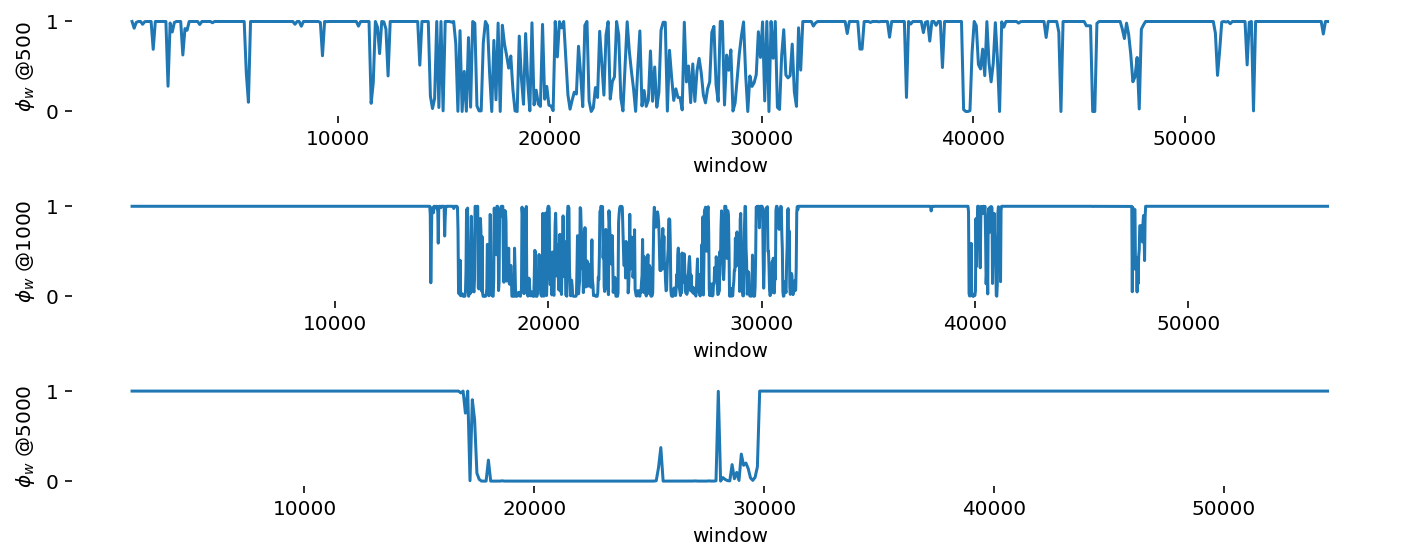

In [114]:
figure( figsize=( 10, 4 ) )

df500 = pandas.read_csv( 'profiles/Profile_w500.csv', header=None )
df500.columns = [ 'window', 'PHI' ]

df1000 = pandas.read_csv( 'profiles/Profile_w1000.csv', header=None )
df1000.columns = [ 'window', 'PHI' ]

df5000 = pandas.read_csv( 'profiles/Profile_w5000.csv', header=None )
df5000.columns = [ 'window', 'PHI' ]

for n,(df,scansize) in enumerate( [ ( df500, '500'), (df1000, '1000'), (df5000, '5000') ] ) :
    subplot( 3, 1, n+1 )
    ax = seaborn.lineplot( df.window,  df.PHI )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([10000,20000,30000,40000,50000])

    ylabel( r'$\phi_w$ @' + scansize )

tight_layout()

Map $\phi_w$ values from alignment coordinates to reference genome coordinates.

Text(0, 0.5, 'alignment coordinates')

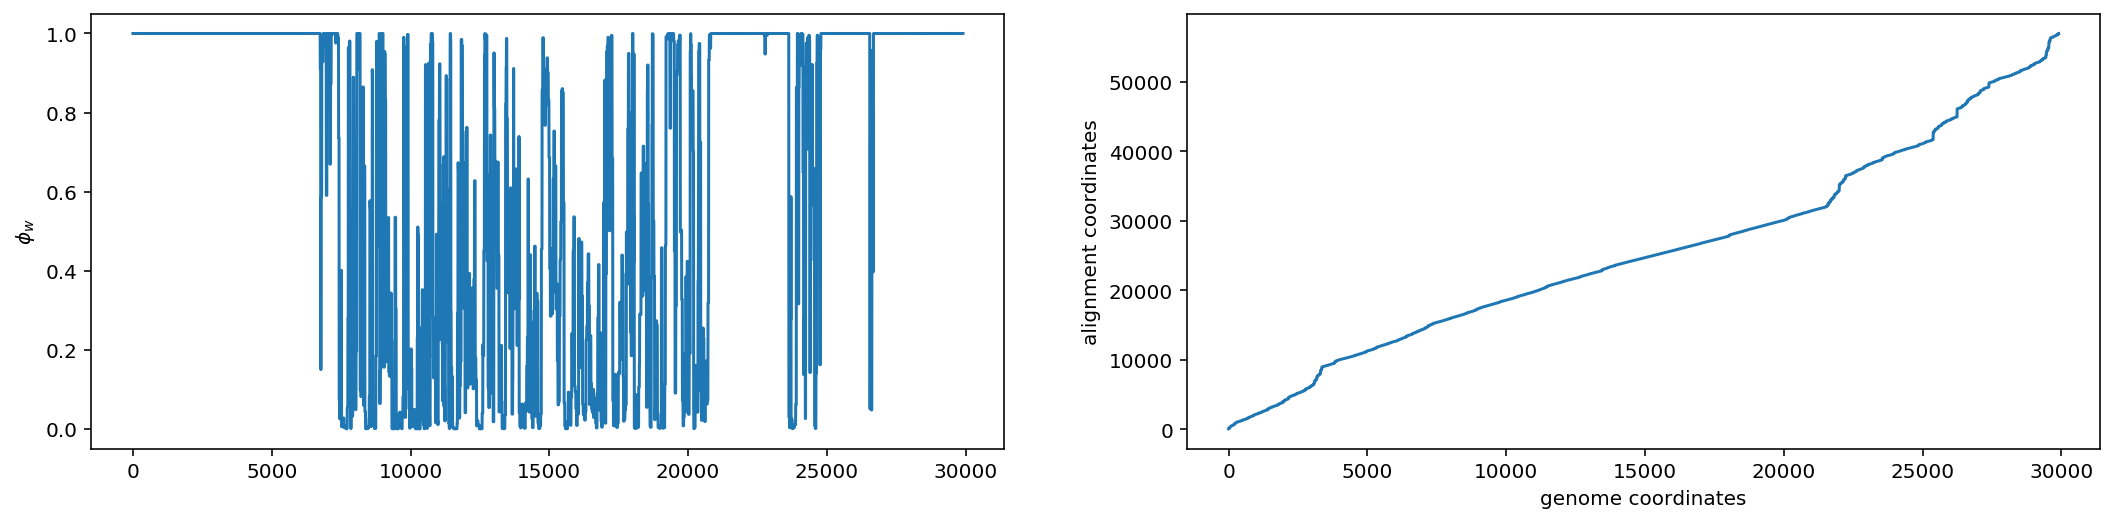

In [109]:
from Bio import SeqIO

figure( figsize=( 18, 4 ) )

# find the reference genome in the alignment
with open( 'data/refcov89_fullgenome_alignment.fasta' ) as f :
    for record in SeqIO.parse( f, format='fasta' ) :
        if record.id.split('|')[0] == 'NC_045512' : break

COVIDref = record

mapping = zeros(len(record))
mapping[:] = 1
gapping = []

for n,row in df1000.iterrows() :
    mapping[ int(row.window - 500) : int(row.window + 499) ] = row.PHI

PHI = zeros( len( str( record.seq).replace('-','') ) )
j = 0
for n,i in enumerate( record.seq ) :
    if i != '-' :
        gapping.append(n)
        PHI[j] = mapping[n]
        j = j+1
    
subplot( 1, 2, 1 )
seaborn.lineplot( range(len(PHI)), PHI )
ylabel( r'$\phi_w$' )
subplot( 1, 2, 2 )
plot( gapping )
xlabel( 'genome coordinates' )
ylabel( 'alignment coordinates' )

Plot $\phi_w$ against the SARS-CoV-2 reference genome annotations, identify
regions where recombination is not likely to have occurred.

In [110]:
import gffpandas.gffpandas as gffpd

annotations = gffpd.read_gff3( 'data/annotations.gff' )
annotations.df.head()

,seq_id,source,type,start,end,score,strand,phase,attributes
0,NC_045512.2,RefSeq,region,1,29903,.,+,.,ID=NC_045512.2:1..29903;Dbxref=taxon:2697049;c...
1,NC_045512.2,RefSeq,five_prime_UTR,1,265,.,+,.,ID=id-NC_045512.2:1..265;gbkey=5'UTR
2,NC_045512.2,RefSeq,gene,266,21555,.,+,.,ID=gene-GU280_gp01;Dbxref=GeneID:43740578;Name...
3,NC_045512.2,RefSeq,CDS,266,13468,.,+,0,ID=cds-YP_009724389.1;Parent=gene-GU280_gp01;D...
4,NC_045512.2,RefSeq,CDS,13468,21555,.,+,0,ID=cds-YP_009724389.1;Parent=gene-GU280_gp01;D...


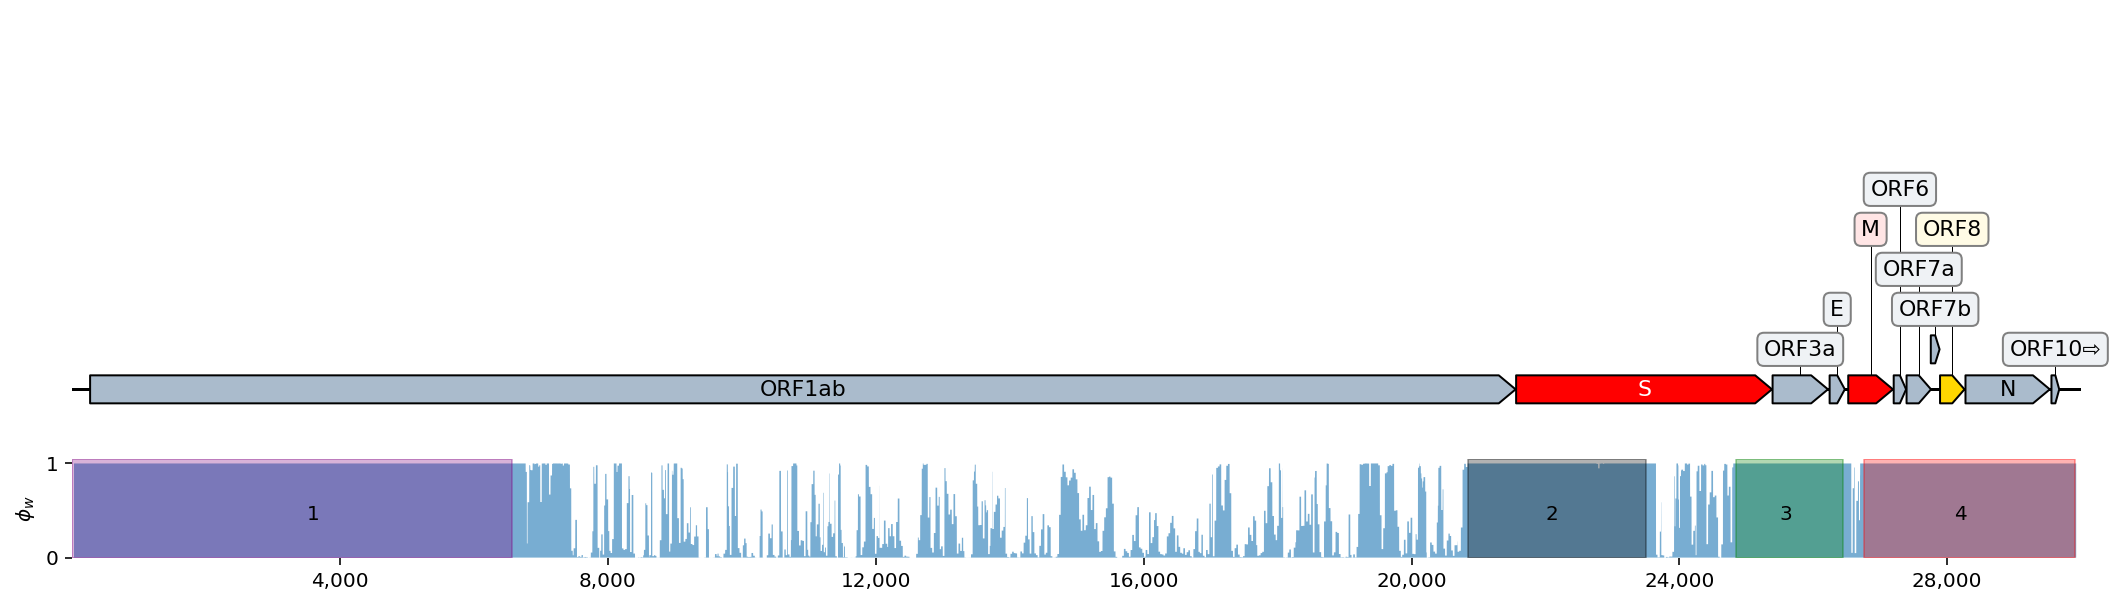

In [111]:
from dna_features_viewer import GraphicFeature, GraphicRecord

fig, (ax1, ax2) = subplots(
    2, 1, figsize=(18, 5), sharex=True, gridspec_kw={"height_ratios": [4, 1]}
)

# Feature map

replication = [ 'ORF1ab' ]
target      = [ 'ORF8' ]
surface     = [ 'S', 'M' ]

features = []

for i,row in annotations.filter_feature_of_type( ['gene'] ).df.iterrows() :
    attributes = { a.split('=')[0]:a.split('=')[1] for a in row.attributes.split(';') }
    if attributes['Name'] in target        : color = '#ffd700'
    #elif attributes['Name'] in replication : color = '#aabbcc'
    elif attributes['Name'] in surface     : color = '#ff0000'
    else                                   : color = '#aabbcc'
    features.append( GraphicFeature( start=row.start,
                                     end=row.end,
                                     strand=+1,
                                     color=color,
                                     label=attributes['Name'] ) )

grecord = GraphicRecord(sequence_length=30000, features=features)
grecord.plot( ax=ax1, with_ruler=False, strand_in_label_threshold=4 )

# Track plot

xx = np.arange( len(PHI) )
ax2.fill_between( xx + 25, PHI, alpha=0.6 )
ax2.set_ylim( bottom=0 )
ax2.set_ylabel( r'$\phi_w$' )
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.get_xaxis().set_ticks([4000,8000,12000,16000,20000,24000,28000])

axvspan( 0,     6570, alpha=.3, color='purple' )
axvspan( 20850, 23500, alpha=.3, color='black' )
axvspan( 24850, 26450, alpha=.3, color='green' )
axvspan( 26760, len(PHI), alpha=.3, color='red' )

ax2.text(  3500, 0.4, '1' )
ax2.text( 22000, 0.4, '2' )
ax2.text( 25500, 0.4, '3' )
ax2.text( 28100, 0.4, '4' )

savefig( 'figures/breakpoints.pdf' )

In [112]:
# non-recombining block coordinates in SARS-CoV-2 reference genome coordinates
block1g = ( 0,      6570        )
block2g = ( 20850, 23500        )
block3g = ( 24850, 26450        )
block4g = ( 26760, len(PHI) - 1 )
blocksg = [ block1g, block2g, block3g, block4g ]

# non-recombining block coordinates in alignment coordinates
blocksa = [ ( gapping[a], gapping[b] ) for a,b in blocksg ]
block1a, block2a, block3a, block4a = blocksa

Create alignment files for each of the four non-recombining regions.

In [115]:
from Bio import SeqIO

# alignments for NRRs
for n,(start,stop) in enumerate( blocksa ) :
    with open( 'data/block_' + str(n+1) + '_aln.fasta', 'w' ) as output :
        with open( 'data/refcov89_fullgenome_alignment.fasta' ) as f :
            for record in SeqIO.parse( f, format='fasta' ) :
                output.write( record[ start:stop ].format( 'fasta' ) )

# alignments for genes
for i,row in annotations.filter_feature_of_type( ['gene'] ).df.iterrows() :
    attributes = { a.split('=')[0]:a.split('=')[1] for a in row.attributes.split(';') }
    name = attributes['Name'] 
    with open( 'data/refcov89_' + name + '_aln.fasta', 'w' ) as output :
        with open( 'data/refcov89_fullgenome_alignment.fasta' ) as f :
            for record in SeqIO.parse( f, format='fasta' ) :
                output.write( record[ row.start:row.end ].format( 'fasta' ) )

Build maximum likelihood phylogenetic trees for each non-recombining region
and our gene of interest (ORF8) using RAxML.

In [ ]:
!raxmlHPC-PTHREADS-AVX -m GTRGAMMA -s data/block_1_aln.fasta -n block_1 -p 1024 -T 8 --silent
!raxmlHPC-PTHREADS-AVX -m GTRGAMMA -s data/block_2_aln.fasta -n block_2 -p 1024 -T 8 --silent
!raxmlHPC-PTHREADS-AVX -m GTRGAMMA -s data/block_3_aln.fasta -n block_3 -p 1024 -T 8 --silent
!raxmlHPC-PTHREADS-AVX -m GTRGAMMA -s data/block_4_aln.fasta -n block_4 -p 1024 -T 8 --silent
!raxmlHPC-PTHREADS-AVX -m GTRGAMMA -s data/refcov89_ORF8_aln.fasta -n block_4 -p 1024 -T 8 --silent
!mv RAxML_* trees/

Examine the topological dissimilarity among the trees inferred for each
non-recombining region.

block_1 vs. block_2 :  KendalltauResult(correlation=0.2351665564476867, pvalue=6.952951126223239e-108)
block_1 vs. block_3 :  KendalltauResult(correlation=0.3948561905482213, pvalue=1.9950174765071034e-300)
block_1 vs. block 4 :  KendalltauResult(correlation=0.2213518317439754, pvalue=8.392266000985188e-96)
block_1 vs. ORF8 :  KendalltauResult(correlation=0.3323970091253747, pvalue=1.6188108097557402e-213)
block_2 vs. block_3 :  KendalltauResult(correlation=0.2011395239453511, pvalue=1.941380990081143e-79)
block_2 vs. block 4 :  KendalltauResult(correlation=0.10118243660826524, pvalue=2.2353063767094666e-21)
block_2 vs. ORF8 :  KendalltauResult(correlation=0.2950882205167379, pvalue=1.020072114259377e-168)
block_3 vs. block 4 :  KendalltauResult(correlation=0.3370319493527552, pvalue=1.8392697804385754e-219)
block_3 vs. ORF8 :  KendalltauResult(correlation=0.34168318989722063, pvalue=1.6954920832315205e-225)
block 4 vs. ORF8 :  KendalltauResult(correlation=0.12928347223961503, pvalue=7

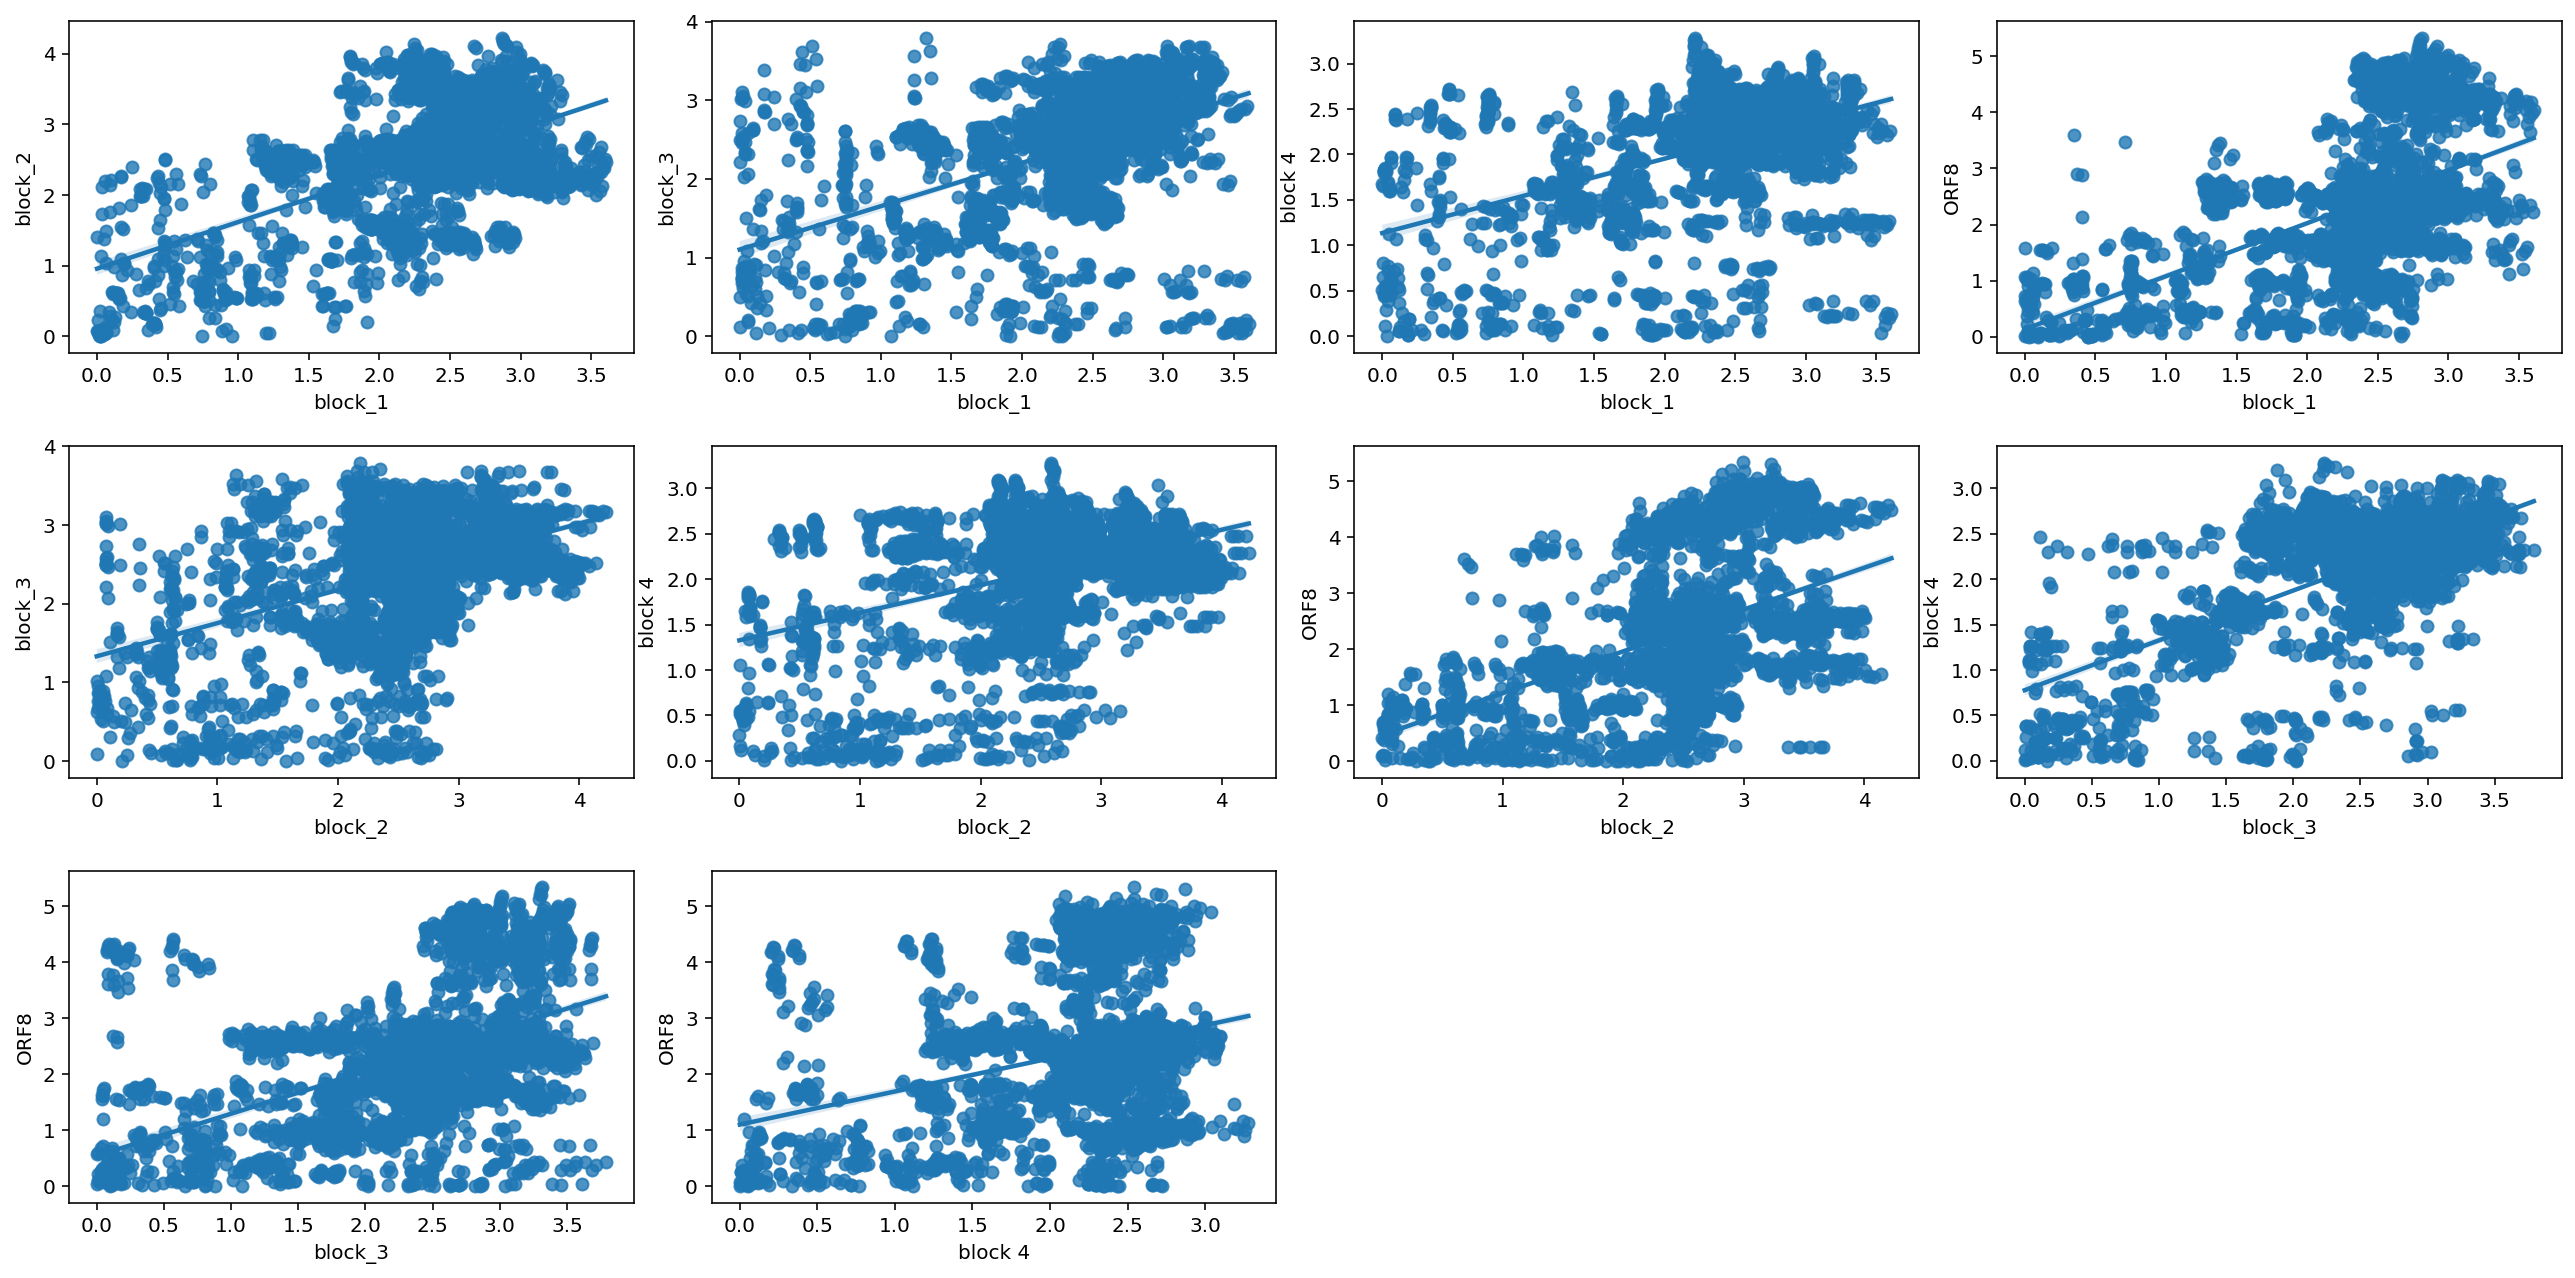

In [116]:
from SuchTree import SuchTree, SuchLinkedTrees
from itertools import combinations
from scipy.stats import pearsonr, kendalltau

figure( figsize=( 18, 9 ) )

block1t = SuchTree( 'trees/RAxML_bestTree.block_1' )
block2t = SuchTree( 'trees/RAxML_bestTree.block_2' )
block3t = SuchTree( 'trees/RAxML_bestTree.block_3' )
block4t = SuchTree( 'trees/RAxML_bestTree.block_4' )
ORF8t   = SuchTree( 'trees/RAxML_bestTree.ORF8'    )

block1d = block1t.distances_by_name( list( combinations( block1t.leafnodes.values(), 2 ) ) )
block2d = block2t.distances_by_name( list( combinations( block2t.leafnodes.values(), 2 ) ) )
block3d = block3t.distances_by_name( list( combinations( block3t.leafnodes.values(), 2 ) ) )
block4d = block4t.distances_by_name( list( combinations( block4t.leafnodes.values(), 2 ) ) )
ORF8d   = ORF8t.distances_by_name(   list( combinations( ORF8t.leafnodes.values(),   2 ) ) )

block_distances = pandas.DataFrame( { 'block_1' : block1d,
                                      'block_2' : block2d,
                                      'block_3' : block3d,
                                      'block 4' : block4d,
                                      'ORF8'    : ORF8d } )

#g = seaborn.PairGrid( block_distances, diag_sharey=False )
#g.map_upper( seaborn.regplot )
#g.map_lower( seaborn.kdeplot, colors="C0" )
#g.map_diag( seaborn.kdeplot, lw=2 )

for n,(a,b) in enumerate( combinations( block_distances.columns, 2 ) ) :
    subplot( 3, 4, n+1 )
    seaborn.regplot( a, b, data=block_distances )
    print( a + ' vs. ' + b + ' : ', kendalltau( block_distances[a], block_distances[b] ) )
    
tight_layout()

In [ ]:
!bali-phy data/refcov89_ORF8_aln.fasta

In [118]:
bplog = pandas.read_csv( 'mcmc/refcov89_ORF8_aln-1/C1.log', sep='\t' )
bplog.head()

,iter,prior,likelihood,posterior,prior_A,|A|,#indels,|indels|,#substs,P1/likelihood,...,Heat.beta,Scale[1],tn93:pi[A],tn93:pi[C],tn93:pi[G],tn93:pi[T],tn93:kappaPyr,tn93:kappaPur,rs07:mean_length,rs07:log_rate
0,0,-142.292922,-11326.612214,-11468.905136,-839.314235,364,83,408,2575,-11326.612214,...,1.0,11.797475,0.319208,0.202627,0.212475,0.265690,3.110450,2.103578,3.976001,-4.485568
1,1,80.016831,-11253.825140,-11173.808309,-634.642509,390,61,362,2509,-11253.825140,...,1.0,13.553893,0.325706,0.194564,0.199141,0.280589,3.381446,1.955976,4.512060,-4.081219
2,2,139.382635,-11211.452802,-11072.070167,-557.275721,376,53,344,2506,-11211.452802,...,1.0,11.701066,0.326366,0.203473,0.204132,0.266029,3.304119,1.964420,4.781739,-4.993881
3,3,212.427364,-11237.474140,-11025.046775,-479.822404,379,45,305,2520,-11237.474140,...,1.0,10.880619,0.319935,0.205416,0.206081,0.268569,2.989935,1.932124,6.288707,-4.401384
4,4,350.653338,-11263.215205,-10912.561867,-338.368251,364,30,227,2535,-11263.215205,...,1.0,11.575343,0.316831,0.202388,0.216171,0.264610,3.326594,1.950575,6.359165,-4.764643


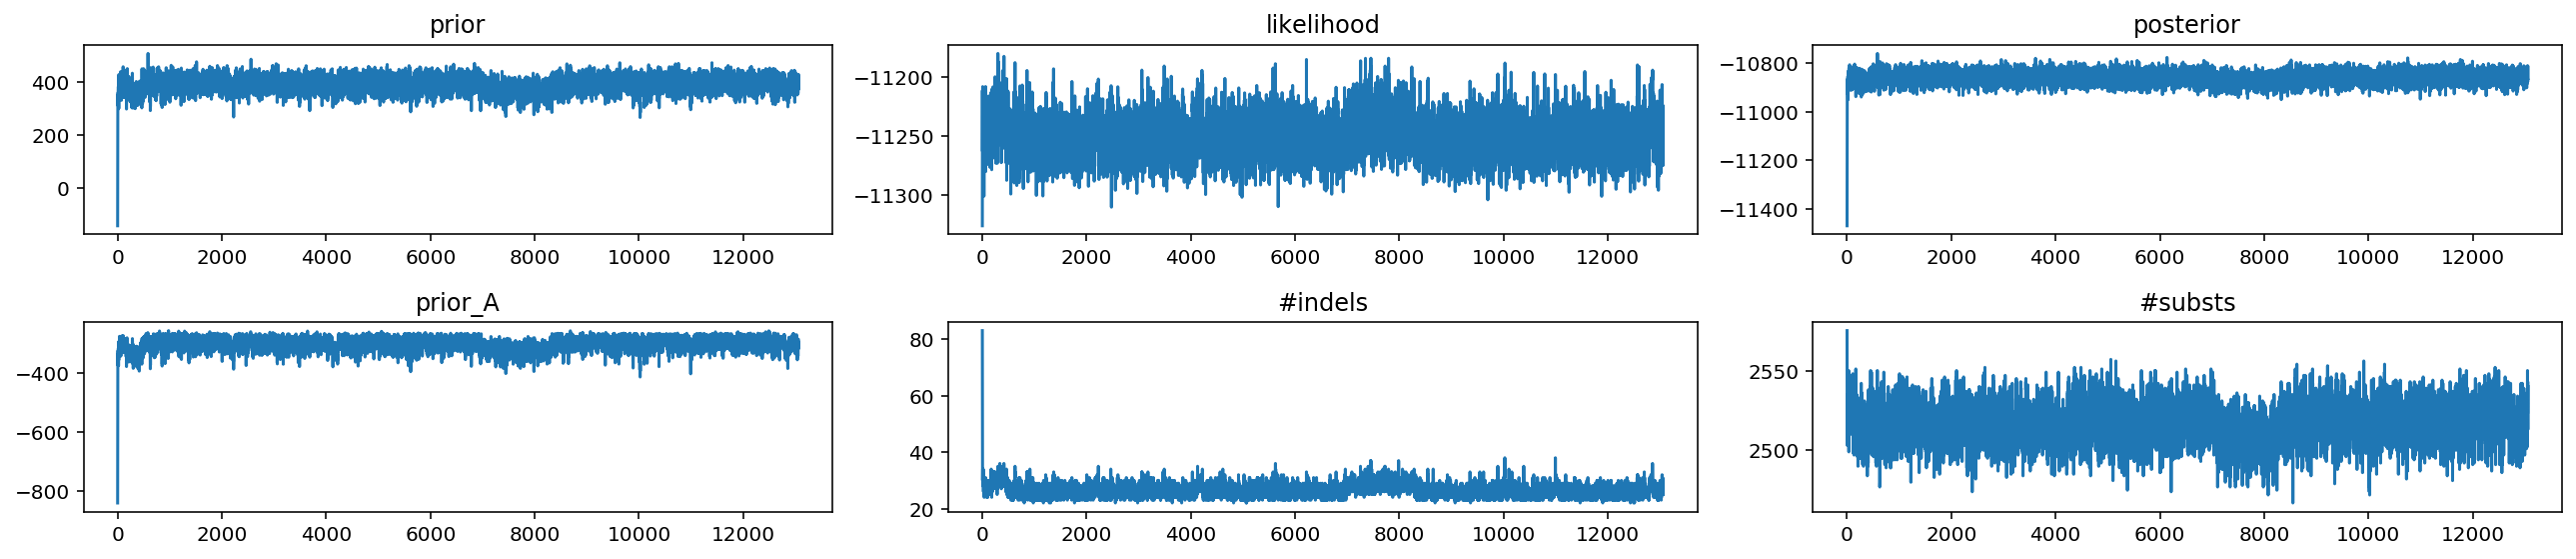

In [119]:
figure( figsize=( 18, 4 ) )

subplot( 2, 3, 1 )
plot( bplog['prior'] )
title( 'prior' )
subplot( 2, 3, 2 )
plot( bplog['likelihood'] )
title( 'likelihood' )
subplot( 2, 3, 3 )
plot( bplog['posterior'] )
title( 'posterior' )
subplot( 2, 3, 4 )
plot( bplog['prior_A'] )
title( 'prior_A' )
subplot( 2, 3, 5 )
plot( bplog['#indels'] )
title( '#indels' )
subplot( 2, 3, 6 )
plot( bplog['#substs'] )
title( '#substs' )

tight_layout()

This appears to be well mixed.

In [124]:
!trees-consensus mcmc/refcov89_ORF8_aln-1/C1.trees > trees/orf8.tree

<img src=figures/orf8_tree.svg>

The majority tree for ORF8 has no recombination events. Next, let's expand the scope
to include the rest of the genes in NRR 4 (ORF6, ORF7a, ORF7b, ORF8, N and ORF10).

In [ ]:
!bali-phy -c bp_block4.txt

In [121]:
bplog = pandas.read_csv( 'mcmc/block_4_analysis-1/C1.log', sep='\t' )
bplog.head()

,iter,prior,likelihood,posterior,prior_A,|A|,#indels,|indels|,#substs,P1/likelihood,...,I2/rs07:mean_length,I2/rs07:log_rate,I3/rs07:mean_length,I3/rs07:log_rate,I4/rs07:mean_length,I4/rs07:log_rate,I5/rs07:mean_length,I5/rs07:log_rate,I6/rs07:mean_length,I6/rs07:log_rate
0,0,-3701.955053,-91020.068477,-94722.023530,-4221.224428,2417,253,1507,20183,-7273.025430,...,2.399124,-3.059978,5.264773,-3.648763,16.057685,-4.303261,37.561054,-4.379634,1.857767,-4.872658
1,1,-2752.944648,-90064.111614,-92817.056262,-3294.472421,2723,301,2076,19796,-7150.851499,...,3.374234,-6.304583,8.963575,-3.233855,15.272378,-4.446524,30.200321,-4.932316,4.606155,-8.633405
2,2,-1822.548610,-90140.379618,-91962.928228,-2399.523823,2512,214,1555,19894,-7259.605971,...,3.401413,-6.766529,9.616761,-4.057793,16.117662,-4.607355,6.437903,-5.340009,9.453254,-7.213879
3,3,-1507.754728,-90168.633895,-91676.388623,-2072.444883,2488,182,1413,19919,-7264.964994,...,5.472221,-6.832219,8.970135,-4.084241,9.022493,-4.580574,5.173280,-5.338881,13.515368,-7.768697
4,4,-1597.504435,-90123.831848,-91721.336284,-2134.221032,2508,189,1457,19916,-7266.711755,...,6.283646,-6.339500,9.018867,-3.896198,9.427572,-4.495721,5.990058,-5.715722,8.675754,-7.815344


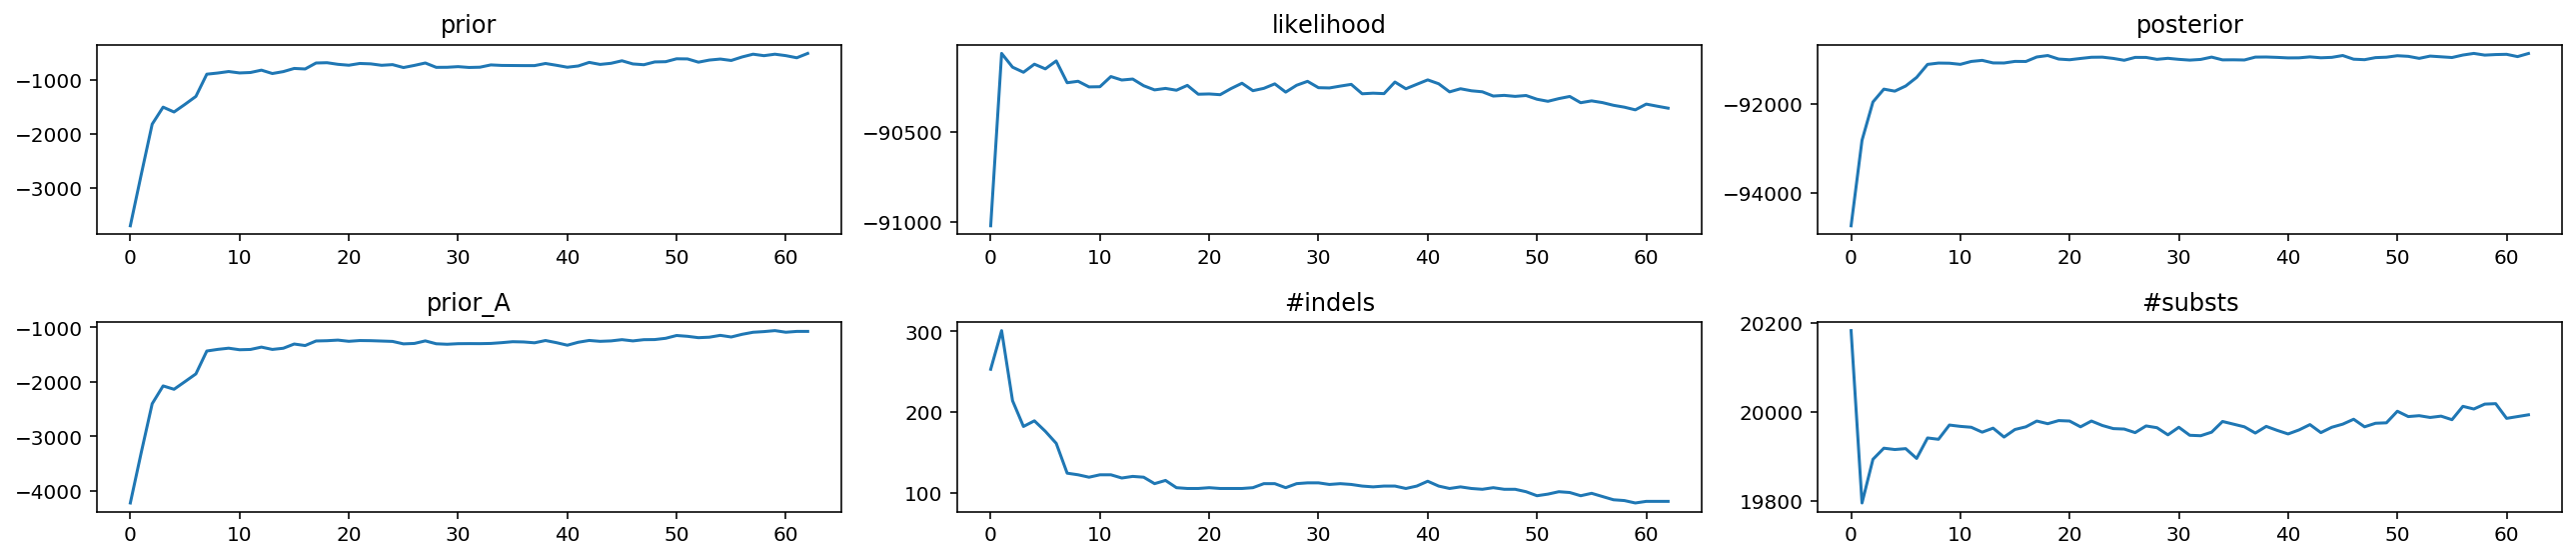

In [122]:
figure( figsize=( 18, 4 ) )

subplot( 2, 3, 1 )
plot( bplog['prior'] )
title( 'prior' )
subplot( 2, 3, 2 )
plot( bplog['likelihood'] )
title( 'likelihood' )
subplot( 2, 3, 3 )
plot( bplog['posterior'] )
title( 'posterior' )
subplot( 2, 3, 4 )
plot( bplog['prior_A'] )
title( 'prior_A' )
subplot( 2, 3, 5 )
plot( bplog['#indels'] )
title( '#indels' )
subplot( 2, 3, 6 )
plot( bplog['#substs'] )
title( '#substs' )

tight_layout()

This looks well mixed. 

In [125]:
!trees-consensus mcmc/block_4_analysis-1/C1.trees > trees/block4.tree

<img src=figures/block4_tree.svg>

The topology of the ORF8 tree closely matches the topology of the tree built from 
all of the genes embedded withing the fourth non-recombing region. Note the significant
improvement over the maximum likelihood trees ( $\tau = 0.13$, $p = 7.3 \times 10^{-34}$ 
verses $\tau = 0.6$, $p \approx 0$).

KendalltauResult(correlation=0.581713987460424, pvalue=0.0)


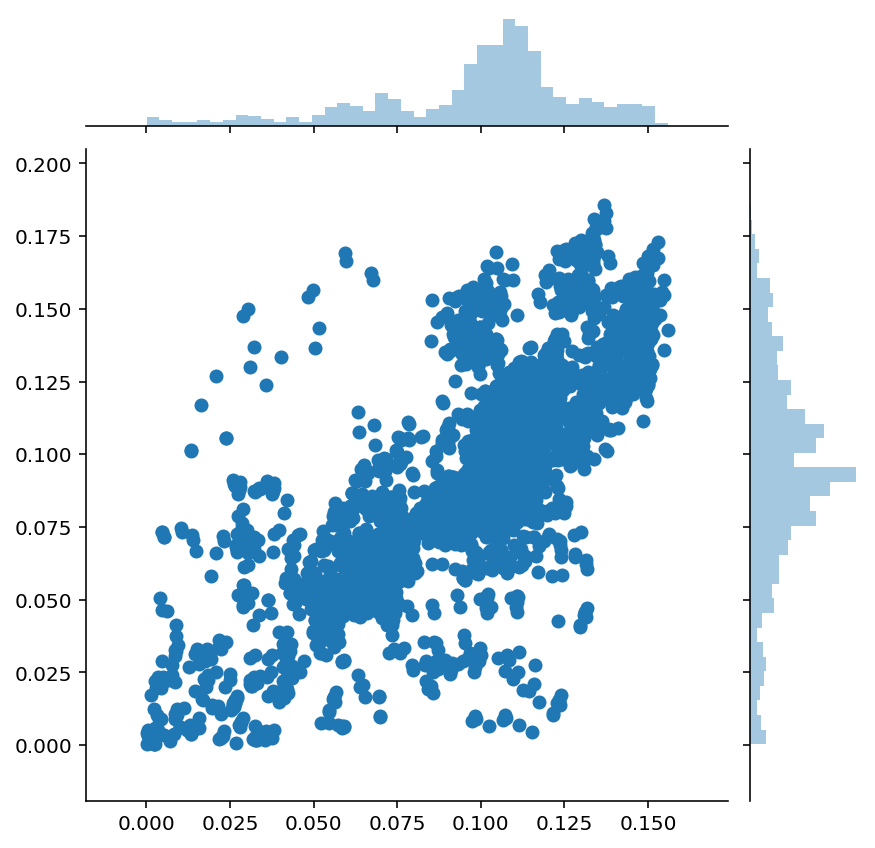

In [127]:
block4tbp = SuchTree( 'trees/block4.tree' )
orf8tbp   = SuchTree( 'trees/orf8.tree' )

block4dbp = block4tbp.distances_by_name( list( combinations( block4tbp.leafnodes.values(), 2 ) ) )
orf8tbp   = orf8tbp.distances_by_name(   list( combinations( orf8tbp.leafnodes.values(), 2 ) ) )

print( kendalltau( block4dbp, orf8tbp ) )
seaborn.jointplot( block4dbp, orf8tbp )

In [4]:
bplog = pandas.read_csv( 'mcmc/block3_4_analysis-1/C1.log', sep='\t' )
bplog.head()

,iter,prior,likelihood,posterior,prior_A,|A|,#indels,|indels|,#substs,P1/likelihood,...,S4/tn93:kappaPyr,S4/tn93:kappaPur,I1/rs07:mean_length,I1/rs07:log_rate,I2/rs07:mean_length,I2/rs07:log_rate,I3/rs07:mean_length,I3/rs07:log_rate,I4/rs07:mean_length,I4/rs07:log_rate
0,0,-1098.297815,-80627.437587,-81725.735402,-1703.830876,2083,122,589,17702,-11548.843954,...,2.992857,2.004402,4.109347,-4.631171,2.489184,-4.185621,3.598886,-4.141881,8.256977,-4.225422
1,1,-714.900249,-80008.766303,-80723.666552,-1259.856554,2137,103,685,17543,-11415.470698,...,2.853943,1.939743,5.705073,-4.643069,16.469383,-9.533522,2.731948,-23.701776,10.461156,-8.757405
2,2,-426.561980,-80072.228417,-80498.790397,-988.014022,2084,86,559,17585,-11394.932550,...,3.266424,1.878859,5.648958,-4.722738,18.313971,-8.114542,2.399990,-7.498943,7.726879,-7.324938
3,3,-88.272342,-80080.148463,-80168.420805,-668.422196,2076,59,413,17599,-11400.053225,...,3.203337,2.006219,5.619238,-4.653114,17.317362,-9.390574,1.166201,-10.189739,6.585192,-7.692432
4,4,-40.488557,-80125.105399,-80165.593957,-623.274365,2046,56,357,17618,-11403.550521,...,2.917672,1.840673,6.413099,-4.997258,4.272202,-8.224678,5.139842,-10.686627,5.617913,-7.516705


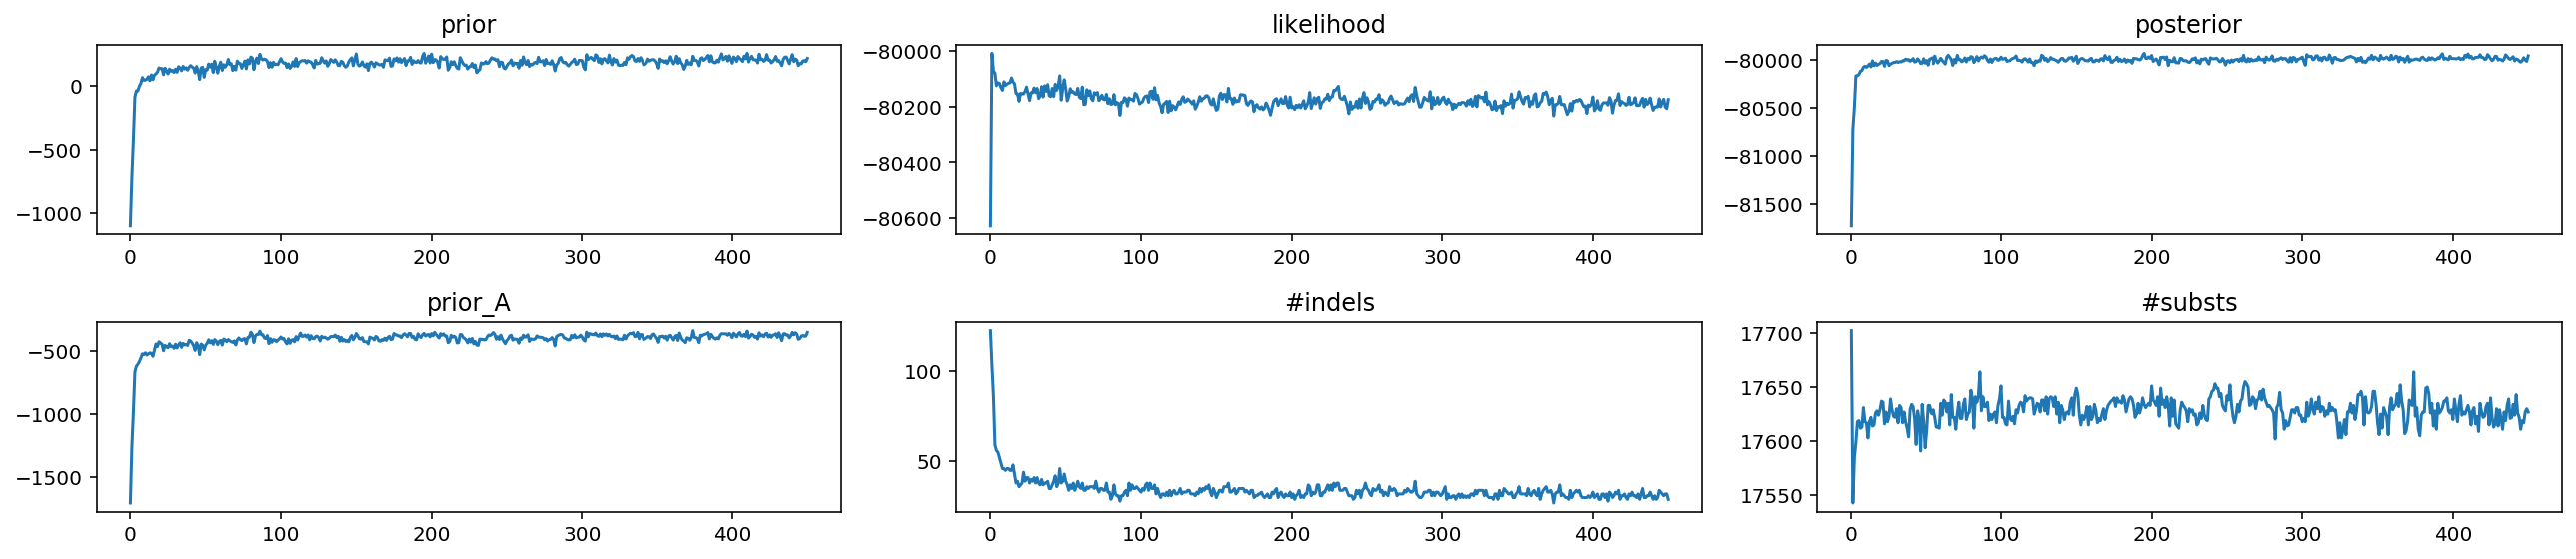

In [5]:
figure( figsize=( 18, 4 ) )

subplot( 2, 3, 1 )
plot( bplog['prior'] )
title( 'prior' )
subplot( 2, 3, 2 )
plot( bplog['likelihood'] )
title( 'likelihood' )
subplot( 2, 3, 3 )
plot( bplog['posterior'] )
title( 'posterior' )
subplot( 2, 3, 4 )
plot( bplog['prior_A'] )
title( 'prior_A' )
subplot( 2, 3, 5 )
plot( bplog['#indels'] )
title( '#indels' )
subplot( 2, 3, 6 )
plot( bplog['#substs'] )
title( '#substs' )

tight_layout()

This appears to well-mixed.

In [6]:
!trees-consensus mcmc/block3_4_analysis-1/C1.trees > trees/block3_4.tree

<img src=figures/block3_4_tree.svg>

([<matplotlib.axis.XTick at 0x7f15b096f8d0>,
 <a list of 23 Text xticklabel objects>)

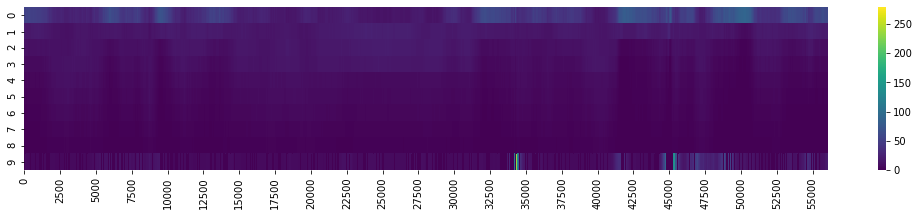

In [242]:
incompatibility_scores = []
centers = []

for i,block in enumerate( open( 'Profile_w1000.log' ).read().split( 'Checking for recombination at ' ) ) :
    if i == 0 : continue # skip the log header
    block = block.split('\n')
    center, X, start, X, end = block[0].split()
    centers.append(center)
    scores = []
    for j in range(10) :
        score = block[3+j][6:10]
        try :
            scores.append( float(score) )
        except :
            scores.append( 0 )
    incompatibility_scores.append( scores )

incompatibility_scores = array( incompatibility_scores ).T

figure( figsize=(18,3) )
seaborn.heatmap( incompatibility_scores, cmap='viridis' )
xticks(       [ i for i in range( 0, len(centers), 100 ) ], 
    labels=[ 25*i for i in range( 0, len(centers), 100 ) ] )

## References


1. Rasmussen, Matthew D., Melissa J. Hubisz, Ilan Gronau, and Adam Siepel. 2014. “Genome-Wide Inference of Ancestral Recombination Graphs.” *PLoS Genetics* 10 (5). doi:10.1371/journal.pgen.1004342.
2. Reback, Jeff, Wes McKinney, Jbrockmendel, Joris Van Den Bossche, Tom Augspurger, Phillip Cloud, Gfyoung, et al. 2020. Pandas-Dev/pandas: Pandas 1.1.0 (v1.1.0). *Zenodo*. https://zenodo.org/record/3509134.
3. SciPy 1.0 Contributors, Pauli Virtanen, Ralf Gommers, Travis E. Oliphant, Matt Haberland, Tyler Reddy, David Cournapeau, et al. 2020. “SciPy 1.0: Fundamental Algorithms for Scientific Computing in Python.” *Nature Methods* 17 (3): 261–72. doi:10.1038/s41592-019-0686-2.
4. Stamatakis, Alexandros. 2014. “RAxML Version 8: A Tool for Phylogenetic Analysis and Post-Analysis of Large Phylogenies.” *Bioinformatics* 30 (9): 1312–13. doi:10.1093/bioinformatics/btu033.
5. Suchard, M. A., and B. D. Redelings. 2006. “BAli-Phy: Simultaneous Bayesian Inference of Alignment and Phylogeny.” *Bioinformatics* 22 (16): 2047–48. doi:10.1093/bioinformatics/btl175.
6. Waskom, Michael, Olga Botvinnik, Joel Ostblom, Maoz Gelbart, Saulius Lukauskas, Paul Hobson, David C Gemperline, et al. 2020. Mwaskom/seaborn: v0.10.1 (April 2020) (v0.10.1). *Zenodo*. https://zenodo.org/record/3767070.
7. Y. Neches, Russell, and Camille Scott. 2018. “SuchTree: Fast, Thread-Safe Computations with Phylogenetic Trees.” *Journal of Open Source Software* 3 (27): 678. doi:10.21105/joss.00678.


<div class="cite2c-biblio"></div>